In [ ]:
# generate data
from data_process import prepare_data

input_dir = mat_file = 'D:/Download/Datasets/Ninapro/DB5'
output_dir = 'datasets/DB5/'
exercise = 1
subjects = [1,2,3,4,5,6,7,8,9,10]
classes = range(1, 13)
repetitions = range(1, 7)
window_length = 50
stride = 5
prepare_data(input_dir, output_dir, exercise, subjects, classes, repetitions, window_length, stride)

In [ ]:
# show data
import torch
from matplotlib import pyplot as plt
import numpy as np
from data_process import load_emg_label, normal2LT, uniform_distribute

file_fmt = 'datasets/DB5/s%d/repetition%d.pt'
data_volume_statistics = 'res/data_volume.csv'
num_subjects = 11
train_data_volume = []
val_data_volume = []
test_data_volume = []
with open(data_volume_statistics, 'w') as f:
    f.write('subject number, training data volume, validation data volume, test data volume, imbalance rate\n')
    for subject in range(1, num_subjects):
        train_rep = [1, 2, 3, 4]
        val_rep = [5]
        test_rep = [6]
        subjects = [subject]
        x_train, y_train = load_emg_label(train_rep, file_fmt, subjects, [])
        x_val, y_val = load_emg_label(val_rep, file_fmt, subjects, [])
        x_test, y_test = load_emg_label(test_rep, file_fmt, subjects, [])
        x_train, y_train = normal2LT(x_train, y_train)
        x_val, y_val = uniform_distribute(x_val, y_val)
        x_test, y_test = uniform_distribute(x_test, y_test)

        train_volume = np.bincount(y_train)
        val_volume = np.bincount(y_val)
        test_volume = np.bincount(y_test)
        train_data_volume.append(train_volume)
        val_data_volume.append(val_volume)
        test_data_volume.append(test_volume)

        f.write('subject %d,%d,%d,%d,%.2f\n' % 
                (subject, y_train.shape[0], y_val.shape[0], y_test.shape[0], train_volume[0] / train_volume[-1]))

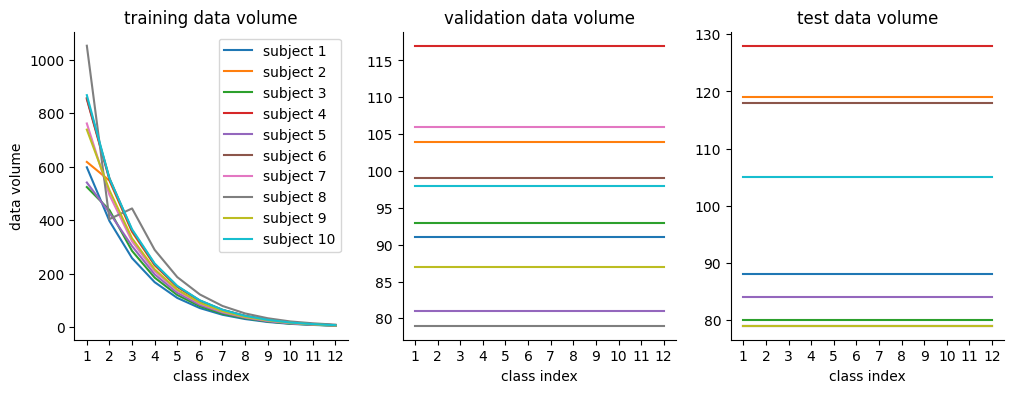

In [10]:
# show data
import torch
from matplotlib import pyplot as plt
import numpy as np
from data_process import load_emg_label, normal2LT, uniform_distribute

file_fmt = 'datasets/DB5/s%d/repetition%d.pt'
data_volume_statistics = 'res/data_volume.csv'
num_subjects = 10
train_data_volume = []
val_data_volume = []
test_data_volume = []
with open(data_volume_statistics, 'w') as f:
    f.write('subject number, training data volume, validation data volume, test data volume, imbalance rate\n')
    for subject in range(1, num_subjects + 1):
        train_rep = [1, 2, 3, 4]
        val_rep = [5]
        test_rep = [6]
        subjects = [subject]
        x_train, y_train = load_emg_label(train_rep, file_fmt, subjects, [])
        x_val, y_val = load_emg_label(val_rep, file_fmt, subjects, [])
        x_test, y_test = load_emg_label(test_rep, file_fmt, subjects, [])
        x_train, y_train = normal2LT(x_train, y_train)
        x_val, y_val = uniform_distribute(x_val, y_val)
        x_test, y_test = uniform_distribute(x_test, y_test)

        train_volume = np.bincount(y_train)
        val_volume = np.bincount(y_val)
        test_volume = np.bincount(y_test)
        train_data_volume.append(train_volume)
        val_data_volume.append(val_volume)
        test_data_volume.append(test_volume)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
x = list(range(1, 13))
for i in range(num_subjects):
    axes[0].plot(x, train_data_volume[i], label=f'subject {i + 1}')
    axes[1].plot(x, val_data_volume[i])
    axes[2].plot(x, test_data_volume[i])

titles = ['training data volume', 'validation data volume', 'test data volume']
for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].set_title(titles[i])
    axes[i].set_xticks(x)
    axes[i].set_xlabel('class index')

axes[0].set_ylabel('data volume')
axes[0].legend(loc="upper right")
# plt.show()
plt.savefig('res/img/data_volume_trend.png', bbox_inches='tight', dpi=600)

In [ ]:
from main_baseline import main
from loss import edl_mse_loss, cross_entropy
from baseline import TCN, CNN2DEncoder, ECNN_Model
from functools import partial


models = [CNN2DEncoder, ECNN_Model, TCN] #
model = models[0]
subject = 2
dist_path = 'res/img/subject2-test-CNN-variable'
if 'ECNN' in model.__name__:
    loss_func = partial(edl_mse_loss, ecnn_type=0)
else:
    loss_func = cross_entropy
main(model, subjects=subject, loss_func=loss_func, dist_path=dist_path)



In [ ]:
from main_db5_moe import main
subjects = [2]
num_experts = 1
main(subjects, num_experts, reweight_epoch=30, uncertainty_type='DST', dist_path='res/img/subject2-test-DST-variable')

In [16]:
# resemble data
import os
from glob import glob
from functools import cmp_to_key

def cmp(file1, file2):
    if len(file1) > len(file2):
        return 1
    elif len(file1) < len(file2):
        return -1
    elif file1 > file2:
        return 1
    else:
        return -1

results_root = 'res'
results_name = 'results.csv'
results_file = os.path.join(results_root, results_name)

trained_dirs = sorted(glob(results_root + '/*mean_RSM*'), key=cmp_to_key(cmp))


with open(results_file, 'w') as result:
    for trained_dir in trained_dirs:
        file = os.path.join(trained_dir, 'csv/accuracy.csv')
        with open(file, 'r') as source:
            lines = source.readlines()
            for i in range(len(lines)):
                if i == 0:
                    result.write('\n')
                else:
                    result.write(lines[i])
                


In [15]:
#!/usr/bin/python
# encoding=utf-8
import time
import os
import subprocess
import threading

def run_db5(cmd):
    start_time = time.time()
    subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    end_time = time.time()
    print(cmd, 'process time: %.2f' % (end_time - start_time), 's')

fusion=''
variable_cloud_size='--variable_cloud_size'
u_type='RSM'
cmds = [
    f'python main_db5_moe_all.py --subject_range 1 4 {fusion} {variable_cloud_size} --uncertainty_type={u_type}',
    f'python main_db5_moe_all.py --subject_range 5 7 {fusion} {variable_cloud_size} --uncertainty_type={u_type}',
    f'python main_db5_moe_all.py --subject_range 8 10 {fusion} {variable_cloud_size} --uncertainty_type={u_type}',
]


# 并行
threads = []
for cmd in cmds:
    th = threading.Thread(target=run_db5, args=(cmd,))
    th.start()
    threads.append(th)
# 等待线程运行完毕
for th in threads:
    th.join()


python main_db5_moe_all.py --subject_range 5 7  --variable_cloud_size --uncertainty_type=RSM process time: 2783.73 s
python main_db5_moe_all.py --subject_range 8 10  --variable_cloud_size --uncertainty_type=RSM process time: 2957.75 s
python main_db5_moe_all.py --subject_range 1 4  --variable_cloud_size --uncertainty_type=RSM process time: 3214.72 s
